In [ ]:
from pyspark.sql.functions import (
    split, col, when, lit, concat, array, struct, array_distinct,
    substring, expr, size, regexp_replace, udf, count
)
from pyspark.sql.types import StringType
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.sql import SparkSession

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import numpy as np
from google.colab import drive
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
spark = SparkSession.builder.appName("Optimized Spark on Colab").master("local[*]").config("spark.executor.memory", "4g").config("spark.driver.memory", "8g").config("spark.executor.cores", "2").config("spark.driver.maxResultSize", "4g").getOrCreate()
spark.sparkContext.getConf().getAll()


[('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.executor.memory', '4g'),
 ('spark.app.startTime', '1733496738799'),
 ('spark.executor.id', 'dr

In [ ]:
#The csv file is taken from the lda&kmeans.ipynb script. Here we have the new target variable cluster_name produced by K-MEANS
file_path = "/content/drive/Shareddrives/DDAM/Datasets aggiornati/df_kmeans"

df = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)
df.show(5)

+---------+----------+----------+----+-----------+-----------+--------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+-------------------+-------+---------+-------------------+-----------+------+--------+--------+----------+--------------------+
|    DR_NO| Date Rptd|  DATE OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|        Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status|Status Desc|Crm Cd 3|Crm Cd 4|           LOCATION|    LAT|      LON|           TIME OCC|time_of_day|season|Crm Cd 1|Crm Cd 2|prediction|        cluster_name|
+---------+----------+----------+----+-----------+-----------+--------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+------

In [ ]:
# Taking the text file in order to map the MO codes into meaningful text.
mapping_file = "/content/drive/Shareddrives/DDAM/3_Research_Question/MO_CODES_explanation.txt"

mapping_dict = {}
with open(mapping_file, 'r') as f:
    for line in f:
        line = line.strip()  # To remove redundant spaces
        if not line:  # if empty
            continue
        try:
            key, value = line.split(None, 1)
            mapping_dict[key] = value
        except ValueError:
            print(f"Riga mal formattata: '{line}'")

In [ ]:
# Broadcasting the dictionary: good for sharing static, read-only data efficiently across a Spark cluster
broadcast_mapping = spark.sparkContext.broadcast(mapping_dict)

In [ ]:
#  Creating a function that maps codes into text
def map_code_to_word(codes):
    if codes is None or codes.strip() == "":
        return "No Code"  # O un valore predefinito
    code_list = codes.split(" ")
    meanings = [broadcast_mapping.value.get(code, "Unknown Code") for code in code_list]
    return " ".join(meanings)
map_udf = udf(map_code_to_word, StringType())

# Updating the DataFrame
df_with_words = df.withColumn("Meaning", map_udf(df["MOCODES"]))
df_with_words.select('Mocodes','Meaning').show(truncate=False)

+-----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Mocodes                      |Meaning                                                                                                                                                          |
+-----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1822 0100 0344               |Stranger Suspect Impersonate Removes vict property                                                                                                               |
|0344                         |Removes vict property                                                                                                                                            |
|0522 1258 0602 0360 0551 0913

In [ ]:
df_with_words = df_with_words.select('AREA NAME','DR_NO','Premis Desc','Weapon Desc','Meaning','Vict Sex','Vict Descent','time_of_day','season','cluster_name')

In [ ]:
df = df_with_words.withColumn("Weapon_Desc_Updated", F.regexp_replace("Weapon Desc", "NO WEAP", "NO_WEAP"))
df = df.withColumn("text", F.concat_ws(" ", F.col("Premis Desc"), F.col("Weapon_Desc_Updated"), F.col("Meaning"),F.col("AREA NAME"),F.col("Vict Sex"),F.col("Vict Descent"),F.col("time_of_day"),F.col("season")))

In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
df = tokenizer.transform(df)
df.show(1, truncate = False)

# Stopwords removal step (Some terms were added manually after some trials)
custom_stopwords = {"vict", "susp", "-", "etc", "no_weap", "&", "mo", ")", "(", "any", "also","is/was", "w/", "crm", "agnst", "victim", "victim's", "thru", "b/w", "use", "uses", "used"}
default_stopwords = StopWordsRemover.loadDefaultStopWords("english")
all_stopwords = list(set(default_stopwords).union(custom_stopwords))
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
remover = remover.setStopWords(all_stopwords)

#Update step
df = remover.transform(df)
df.show(1, truncate = False)

# Vectorizer step: after this step, now data are ready to be processed by clustering algorithm.
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features")
model = vectorizer.fit(df)
df = model.transform(df)
df.select('DR_NO','features','filtered_tokens', 'cluster_name').show()

+---------+---------+----------------------+-----------+--------------------------------------------------+--------+----------------------+-----------+------+---------------------------+-------------------+---------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+
|AREA NAME|DR_NO    |Premis Desc           |Weapon Desc|Meaning                                           |Vict Sex|Vict Descent          |time_of_day|season|cluster_name               |Weapon_Desc_Updated|text                                                                                                                             |tokens                                                                                                                                           |
+---------+---------+-------------

In [ ]:
# Calculate proportions for 'cluster_name' column
topic_proportions = df.groupBy("cluster_name").agg(count("*").alias("count")) \
    .withColumn("proportion", col("count") / df.count())

# Display the results
topic_proportions.show()

+--------------------+------+--------------------+
|        cluster_name| count|          proportion|
+--------------------+------+--------------------+
|Aggression and In...|  5079|0.005168739657941175|
|Cyber and Verbal ...| 77044| 0.07840527233833823|
|Violence and Sexu...| 38812| 0.03949776011104802|
|Discrimination an...| 61107|0.062186685228944945|
|Stalking and Work...| 30913|  0.0314591945355258|
|Family or Interpe...| 21064|0.021436174868059245|
|Weapons and Confr...| 80416| 0.08183685141425429|
|Harassment and Pr...| 25035|0.025477337534269996|
|Educational or So...|  9463|0.009630199524138086|
|Infrastructure an...| 20606|  0.0209700825736436|
|Real Estate or Pr...|  5606|0.005705051097148695|
|     Sexual Violence| 76452| 0.07780281242939922|
|Utilities and Pub...| 15808| 0.01608730783869543|
|Domestic and Phys...| 39350| 0.04004526590667163|
|Workplace or Serv...| 87863| 0.08941543070795145|
|Minor Offenses or...|255654|  0.2601710904727886|
|Identity and Medi...| 16152|0.

# Convolutional Neural Network with K-Means produced clusters

In [ ]:
df.select('DR_NO','features','filtered_tokens', 'cluster_name').show(truncate = False)

+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------+
|DR_NO    |features                                                                                                                                                                                                         |filtered_tokens                                                                                                                                                                                                                             

In [ ]:
#This code takes about 4 hours to be fully executed!

# Data Preparation
# Extract columns filtered_tokens and cluster_name from the DataFrame and convert them into RDD format
filtered_tokens_rdd = df.select("filtered_tokens", "cluster_name").rdd

# Convert filtered_tokens into strings and collect cluster_name labels
texts = filtered_tokens_rdd.map(lambda row: " ".join(row["filtered_tokens"])).collect()
labels = filtered_tokens_rdd.map(lambda row: row["cluster_name"]).collect()

# Encode labels as numerical values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenization: Convert texts into sequences of integers, limiting vocabulary size to 10,000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Padding sequences to ensure uniform input size (length = 100)
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences, maxlen=100, padding="post", truncating="post")

# Train-test split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Convert labels to categorical format (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# CNN Model Creation
from tensorflow.keras import Sequential, regularizers

# Define a sequential model
l2 = tf.keras.regularizers.L2(0.001)  # L2 regularization to mitigate overfitting
model = Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=100),  # Embedding layer for word vectors
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation="relu", kernel_regularizer=l2),  # 1D convolution
    tf.keras.layers.GlobalMaxPooling1D(),  # Reduce dimensions by taking max values
    tf.keras.layers.Dropout(0.5),  # Prevent overfitting with dropout
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2),  # Fully connected layer with L2 regularization
    tf.keras.layers.Dropout(0.5),  # Another dropout layer
    tf.keras.layers.Dense(y_train.shape[1], activation="softmax"),  # Output layer for multi-class classification
])

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model for 10 epochs with batch size of 32
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
)

# Evaluate the model on the test set and print the accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1370s 56ms/step - accuracy: 0.7674 - loss: 0.8652 - val_accuracy: 0.8410 - val_loss: 0.5296
Epoch 2/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1322s 54ms/step - accuracy: 0.8163 - loss: 0.6371 - val_accuracy: 0.8360 - val_loss: 0.5315
Epoch 3/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1354s 54ms/step - accuracy: 0.8173 - loss: 0.6336 - val_accuracy: 0.8391 - val_loss: 0.5215
Epoch 4/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1330s 54ms/step - accuracy: 0.8184 - loss: 0.6294 - val_accuracy: 0.8432 - val_loss: 0.5223
Epoch 5/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1357s 55ms/step - accuracy: 0.8194 - loss: 0.6259 - val_accuracy: 0.8412 - val_loss: 0.5222
Epoch 6/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1408s 55ms/step - accuracy: 0.8205 - loss: 0.6207 - val_accuracy: 0.8410 - val_loss: 0.5204
Epoch 7/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1391s 57ms/step - accuracy: 0.8205 - loss: 0.6220 - val_accuracy: 0.8412 - val_loss: 0.5184
Epoch 8/10
24566/24566 ━━━━━━━━━━━━━━━━━━━━ 1367

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:",label_mapping)

Label Mapping: {'Aggression and Intimidation': 0, 'Cyber and Verbal Harassment': 1, 'Discrimination and Personal Spaces': 2, 'Domestic and Physical Threats': 3, 'Domestic or Physical Altercations': 4, 'Educational or Social Venues': 5, 'Family or Interpersonal Conflicts': 6, 'Harassment and Property Issues': 7, 'Identity and Media-Related Crimes': 8, 'Infrastructure and Transit Incidents': 9, 'Minor Offenses or Vandalism': 10, 'Public or Media-Related Crimes': 11, 'Real Estate or Property Crimes': 12, 'Sexual Violence': 13, 'Stalking and Workplace Issues': 14, 'Theft and Suggestive Behavior': 15, 'Utilities and Public Spaces': 16, 'Violence and Sexual Misconduct': 17, 'Weapons and Confrontations': 18, 'Workplace or Service Incidents': 19}


In [ ]:
y_pred = model.predict(X_test)

# Label Decoding
y_pred_labels = np.argmax(y_pred, axis=1)  # Le etichette predette
y_test_labels = np.argmax(y_test, axis=1)  # Le etichette reali

# Calculating the  classification report
report = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)

# Print the classification report
print(report)

6142/6142 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step
                                      precision    recall  f1-score   support

         Aggression and Intimidation       0.91      0.99      0.95       997
         Cyber and Verbal Harassment       0.81      0.67      0.73     15366
  Discrimination and Personal Spaces       0.93      0.98      0.96     12135
       Domestic and Physical Threats       0.98      0.92      0.95      7809
   Domestic or Physical Altercations       0.97      0.98      0.97      7230
        Educational or Social Venues       0.89      0.92      0.91      1839
   Family or Interpersonal Conflicts       0.97      0.94      0.96      4211
      Harassment and Property Issues       0.98      0.94      0.96      5108
   Identity and Media-Related Crimes       1.00      0.99      1.00      3222
Infrastructure and Transit Incidents       0.89      0.93      0.91      4145
         Minor Offenses or Vandalism       0.77      0.86      0.81     50859
      Public or Me

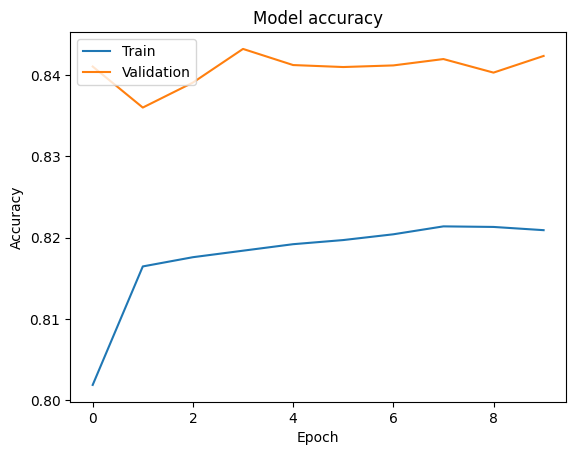

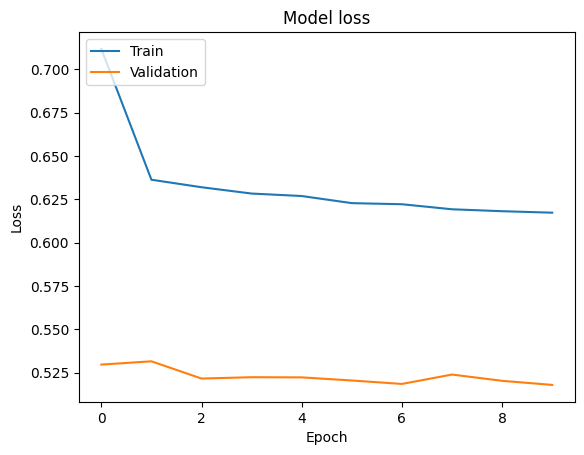

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()